In [205]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from modAL.models import ActiveLearner
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [206]:
df = pd.read_csv('SMILES_energy_patterns.txt', delim_whitespace = True, header = None)

patterns = []

fileinput = open('QM7_300_patterns_v2.txt','r').readlines()
for line in fileinput:
    patterns.append(line.split()[0])

In [207]:
print(patterns)
patterns = np.array(patterns)
print(patterns.shape)

['C', 'N', 'O', 'S', 'c', 'n', 'o', 's', 'C#C', 'C=C', 'CC', 'OC', 'O=C', 'NC', 'N#C', 'N=C', 'ON', 'cc', 'nc', 'sc', 'sn', 'oc', 'on', 'SC', 'S=O', 'COC', 'O=CC', 'OCC', 'OR1CCR1', 'CNC', 'N#CC', 'NCC', 'NR1CCR1', 'C#CC', 'C=CC', 'CCC', 'CR1CCR1', 'NOC', 'ON=C', 'O=CN', 'N=CC', 'OC=C', 'cnc', 'csc', 'ncc', 'scc', 'scn', 'ccc', 'nsc', 'snc', 'NC=C', 'C=NC', 'coc', 'occ', 'ocn', 'noc', 'onc', 'CSC', 'O=SC', 'O=S=O', 'SCC', 'Occ', 'scO', 'Ncc', 'scN', 'SC#C', 'SC=C', 'ncC', 'scC', 'ccC', 'Onc', 'Ocn', 'ocN', 'OCCN', 'C=NOC', 'O=CNC', 'ON=CC', 'OCC#C', 'OCC=C', 'O=CC#C', 'OCCC', 'C=COC', 'COCC', 'O=CCC', 'O=CC=C', 'OR1CCCR1', 'NCC#C', 'NCC=C', 'NCCC', 'CNCC', 'N#CCC', 'N#CC#C', 'N#CC=C', 'NR1CCCR1', 'C#CCC', 'C=CCC', 'CC#CC', 'CC=CC', 'C#CC#C', 'C#CC=C', 'C=CC=C', 'CCCC', 'CR1CCCR1', 'cncc', 'cscc', 'ncsc', 'sccn', 'scnc', 'csnc', 'nccc', 'nscc', 'sccc', 'sncc', 'cccc', 'N=CC#C', 'N=CC=C', 'O=CCN', 'NC=CC', 'NOCC', 'CN=CC', 'O=CN=C', 'N=CCC', 'cocc', 'ncoc', 'occn', 'ocnc', 'conc', 'nocc'

In [208]:
df.iloc[:,2]

0      -417.031
1      -403.695
2      -563.084
3      -711.117
4      -795.364
         ...   
295   -1404.080
296   -1294.540
297   -1556.930
298   -1293.440
299   -1557.390
Name: 2, Length: 300, dtype: float64

In [209]:
y = np.array(df.iloc[:,2])
print(y[np.argmax(y)])
print(y[np.argmin(y)])
print(y.shape)

-403.695
-1599.0
(300,)


In [210]:
#the last pattern is the hydrogen counts
X = np.array(df.iloc[:,3:])

print(X.shape)

(300, 389)


In [211]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)                #choosing the instance with max standard deviation
    
    return query_idx, X[query_idx]

def Initial_trainingSet(n_initial,X_train,y_train):                          #randomly selecting our initial dataset
    initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
    X_training_initial, y_training_initial = X_train[initial_idx], y_train[initial_idx]
    X_training_initial.reshape(n_initial,-1)
    return X_training_initial, y_training_initial

def Query_teach(n_queries, regressor,X_train,y_train):                          #Query and teach for n times
    for idx in range(n_queries):
        query_idx, query_instance = regressor.query(X_train)
        regressor.teach(X_train[query_idx].reshape(1, -1), y_train[query_idx].reshape(1, -1))

def RMSE(y_train,y_predict):
    Minus_train = y_train-y_predict.flatten()
    RMSE = np.sqrt(np.mean(np.square(Minus_train)))
    return RMSE
def Random_select(regressor,X_train):
    initial_idx = np.random.choice(range(len(X_train)), size=1, replace=False)
    return initial_idx, X_train[initial_idx]

In [212]:
#length_scale_bounds=(1e-05, 100000.0))
#result = []
#for i in range (-5,5,1):
#    for j in range (i,5,1):
#        kernel = RBF(length_scale=1, length_scale_bounds=(1*10**i, 1*10**j))
#        gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, y)
#        y_predict = gpr.predict(X)
#        RMSE = np.sqrt(np.mean((y-y_predict)**2))
#        result.append([i,j,RMSE])
#print(result)

In [213]:

#print((np.array(result)[:,2]))

#print(np.array(result)[5,:])

In [214]:
kernel = RBF(length_scale=1, length_scale_bounds=(1e2, 2e3))


X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=0.33)

X_All = X_pool
y_All = y_pool

X_training_initial, y_training_initial= Initial_trainingSet(10,X_pool,y_pool)


print(X_pool.shape)

Active = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy= GP_regression_std,
    X_training=X_training_initial, y_training=y_training_initial.reshape(-1,1)
)
Random = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy= Random_select,
    X_training=X_training_initial, y_training=y_training_initial.reshape(-1,1)
)



RMSE_active = np.array([])
RMSE_random = np.array([])
RMSE_active = np.append(RMSE_active,RMSE(y_test,Active.predict(X_test)))
RMSE_random = np.append(RMSE_random,RMSE(y_test,Random.predict(X_test)))




for i in range(10,100,10):
    Query_teach(10, Random,X_pool,y_pool)
    Query_teach(10, Active,X_pool,y_pool)
    RMSE_active = np.append(RMSE_active,RMSE(y_test,Active.predict(X_test)))
    RMSE_random = np.append(RMSE_random,RMSE(y_test,Random.predict(X_test)))


(201, 389)


C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

In [215]:
print(RMSE_active)


[97.41265324 53.87014171 43.98571487 36.61358252 34.47688944 29.33769353
 24.94768745 18.74265937 14.37814474 11.3075211 ]


In [216]:
print(RMSE_random)
Training_set_size = np.arange(10,110,10)


[97.41265324 89.50086673 57.52627373 42.15557398 33.71582888 28.78291685
 26.17412243 26.588573   26.2203984  23.98224805]


4.611074080983747
(1,)


C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

(1,)


C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

(1,)


C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

(1,)


C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

(1,)


C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

(1,)


C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

(1,)


C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

(1,)


C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

(1,)


C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 100.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\wesle\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarni

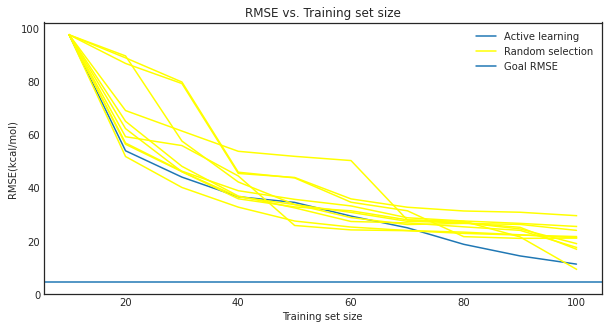

In [217]:
Random.fit(X_All,y_All)
RMSE_Base = RMSE(y_test,Random.predict(X_test))

print(RMSE_Base)


with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.plot(Training_set_size, RMSE_active)
    plt.plot(Training_set_size, RMSE_random,color = 'yellow')
    plt.axhline(y=RMSE_Base)
    plt.legend(['Active learning','Random selection','Goal RMSE'])
    plt.title('RMSE vs. Training set size')
    plt.xlabel('Training set size')
    plt.ylabel('RMSE(kcal/mol)')

for j in range(1,10):
    RMSE_random = np.delete(RMSE_random, [1,2,3,4,5,6,7,8,9], 0)
    print(RMSE_random.shape)
    Random.fit(X_training_initial,y_training_initial.reshape(-1,1))

    
    for i in range(10,100,10):
        Query_teach(10, Random,X_pool,y_pool)
        RMSE_random = np.append(RMSE_random,RMSE(y_test,Random.predict(X_test)))
    
    plt.plot(Training_set_size, RMSE_random,color = 'yellow')



